In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
#from numba import jit

Want to evolve system:
\begin{equation}
    \begin{cases}
    i \hbar \frac{\partial \psi(\vec{x},t)}{\partial t} = \hat{H}\psi(\vec{x},t)\\
    \nabla^2 \Phi = 4 \pi G \rho = 4 \pi G |\psi|^2
    \end{cases}
\end{equation}

Given Hamiltonian:
$$
\hat{H} = \frac{-\hbar^2}{2m}\nabla^2 + \Phi(\vec{x},t)
$$

And with periodic (spatial) boundary conditions on $\Psi$.

Also, set $m = \hbar = 4\pi G = 1$.

Then, for a small time step $\Delta t = t_{i+1}-t_i$, system @ $x_j$ becomes 
\begin{equation}
\begin{cases}
i\frac{\Delta \psi(x_j,t_i)}{\Delta t} = -\frac{1}{2}\frac{d^2 \psi(x_j,t_i)}{dx^2}+\Phi(x_j,t_i)\psi(x_j,t_i) \\
\frac{d^2 \Phi(x_j,t_i)}{dx^2} = |\psi(x_j,t_i)|^2
\end{cases}
\end{equation}

On a 1D grid of N points, and length L, system is approximately:
 
\begin{equation*}
\begin{cases}
i\frac{\Delta \psi(x_j,t_i)}{\Delta t} = -\frac{1}{2}\frac{N^2}{L^2}\left[\psi(x_{j+1})-2\psi(x_j)+\psi(x_{j-1})\right]+\Phi(x_j,t_i)\psi(x_j,t_i)
\\
\frac{N^2}{L^2}\left[\Phi(x_{j+1})-2\Phi(x_j)+\Phi(x_{j-1})\right] = |\psi(x_j,t_i)|^2

\end{cases}
\end{equation*}

In [2]:
def gauss(x,b,std):
    return (1/(2*np.pi))**0.5*np.exp(-(x-b)**2/(2*std**2))

def Laplacian_matrix(N,dx): #N: number points in grid, dx: grid spacing
    f = (1/dx)**2
    array = np.ndarray((N,N))
    for i in range(N):
        for j in range(N):
            if (i == j) and i != 0 and i != len(array):
                array[i,j] = -2*f
            elif (i == j) and (i != 0 or i != len(array)): #this is the correction for the end points
                array[i,j] = -1*f
            elif (i==j-1) or (i==j+1):
                array[i,j] = 1*f
            else: array[i,j] = 0.0
    return array #return the matrix

def Laplacian(y_data, dx):
    N = len(y_data) #our len(y_data) matches number of grid points
    ret = np.dot(Laplacian_matrix(N,dx),y_data)
    return ret


#Build the Hamiltonian on a 1D Grid of N points
#First define the entries of the matrix for KE evolution
#def KE_ij(i,j,N,L):
 #   f = -0.5*N**2/L**2
 #   if (i == j):
 #       return -2*f
 #   elif (i==j-1) or (i==j+1):
 #       return f
 #   else: 
 #       return 0.0
def KE_matrix(N,dx,hbar,m):
    f = -0.5* (hbar**2) *m
    return f*Laplacian_matrix(N,dx)

#Define the potential matrix from the potential field
def U_matrix(phi):
    N = len(phi)
    array = np.ndarray((N,N))
    for i in range(N):
        for j in range(N):
            if i == j:
                array[i,j] = phi[i]
            else:
                array[i,j] = 0.0
    return array

#Put it together to get the Hamiltonian
def H_matrix(phi,dx,hbar,m):
    N = len(phi)
    H = KE_matrix(N,dx,hbar,m) + U_matrix(phi)
    #H = np.ndarray(shape = (N,N))
    #for i in range(N):
    #    for j in range(N):
    #         H[i,j] = KE_ij(i,j,N,L)+U_ij(i,j,phi)
    return H

#Define a Fourier Series function, takes in x-values and fourier Coefficients
def FS(x,P_n):
    #Proceed to calculate Fourier Series at each point:
    for i in range(len(x)):
        sum = 0 
        xx = x[i] #for given point xx, calculate Fourier Sum:
        for nn in range(len(P_n)):
            if nn <= n//2:
                k = 2*np.pi*nn / L
                sum += P_n[nn]*np.exp(k*xx*1j)
            elif nn >= n//2 +1:
                k = -2*np.pi*(nn-n)/L
                sum += P_n[nn]*np.exp(k*xx*1j)
    return output 

## 1. Test if Hamiltonian works to evolve system forward by one time-step
At first I tried using an initial condition on $\Phi$ being a gaussian. I then guessed that $\psi$ is real and non-negative, so that I can just take:
$$\psi(x,t=0) = \sqrt{\frac{d^2 \Psi}{dx^2}(x,t=0)}$$

But gaussian $\Phi$ doesn't really work since this gives a negative result for $\frac{d^2 \Psi}{dx^2}(x,t=0)$, meaning $|\psi(x,t=0)|^2<0$.

C:\Users\boris\AppData\Local\Temp\ipykernel_17640\118296612.py:15: RuntimeWarning: invalid value encountered in sqrt
  psi_init = np.sqrt(psi_init_sq) #assuming psi_init to be real valued and non-negative


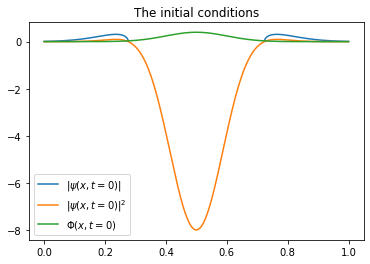

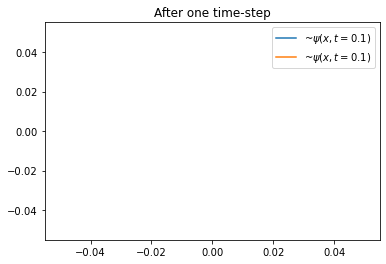

In [3]:
#Build the Initial Condition
N = 1000 #set size
L = 1 #length of periodic box
dx = L/(N+1)
m = 1
hbar = 1

x = np.linspace(0,L,N) #make x data / grid

b=L/2
std=0.1
phi_init = np.array([gauss(xx,b,std) for xx in x])

psi_init_sq = np.array([(4*(xx-b)**2/std**2-2/std)*gauss(xx,b,std) for xx in x]) #twice the derivative of phi_init
psi_init = np.sqrt(psi_init_sq) #assuming psi_init to be real valued and non-negative

#Plot initial conditions
plt.plot(x,psi_init, label = '$|\\psi(x,t=0)|$')
plt.plot(x,psi_init_sq, label = '$|\\psi(x,t=0)|^2$')
plt.plot(x,phi_init, label = '$\Phi(x,t=0)$')
plt.title("The initial conditions")
plt.legend()
plt.show()

#Evolve the system by one time-step
H = H_matrix(phi_init,dx,hbar,m)
Delta_t = 0.1
psi = psi_init-1j*Delta_t*np.dot(H,psi_init) #recalculate psi after the time step

#plt.plot(x,np.dot(H,psi_init), label = '') 
plt.plot(x,np.real(psi),label = '~$\\psi(x,t=0.1)$')
plt.plot(x,np.imag(psi),label = '~$\\psi(x,t=0.1)$')
plt.title("After one time-step")
plt.legend()
plt.show()

Now I want to try setting up an initial $\Phi(x,t=0)$ based off of an initial density $\rho(x,t=0)$. Setting up an initial $\rho(x,t=0)$ allows me to easily set up a real-valued non-negative initial $\psi(x,t=0) \equiv \sqrt{\rho(x,t=0)}$, however to get $\Phi$ from $\rho$ at this point, I already have to create a Fourier Method for solving Poisson's equation. So I dream up a function that does that here.

This function takes in a specified wavefunction array, specifying $\psi(x,t=t_0)$ (at a given time $t_0$), and takes in a number $n$ to specify the number of frequencies to go up to in determining the fourrier coefficients.

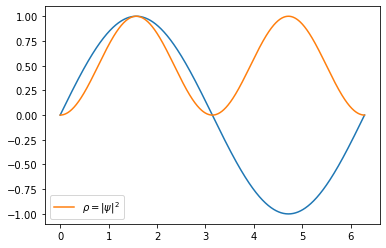

len(phi) = 1000


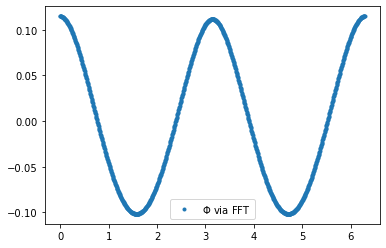

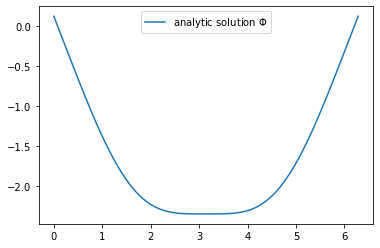

In [4]:
#Real Fourier Series:
def R_FS(x,a_n):
    array = np.array([])
    for i in range(len(x)):
        sum = 0
        xx = x[i]
        for n in range(len(a_n)):
            sum += a_n[n]*np.sin(2*np.pi*n*xx/L)+np.conj(a_n[n])*np.sin(-2*np.pi*n*xx/L)
        array = np.append(array,sum)
    return array

#Determine the potential from poisson's equation using fourier method
def real_fourier_potential(psi):
    n = len(psi)
    
    #1. FFT the norm-squared of the wave-function
    P = np.absolute(psi) #this is the density
    P_n = np.fft.rfft(P,n) #fft for real input
    
    #plt.plot(x,R_FS(x,P_n))
    #plt.title("FS approx. of $\\rho$")
    #plt.show()
    
    #2. Compute the fourier coefficients of phi
    Phi_n = np.array([]) #empty for storage. Will hold the fourier coefficients
    for nn in range(len(P_n)):
        if nn == 0:
            val = 0
        if nn >=1: #for the positive frequencies
            k = 2*np.pi*nn/L
            val = -P_n[nn]/k**2
        Phi_n = np.append(Phi_n,val)
    #print(Phi_n)
    
    
    #3. IFFT back to get Potential
    Phi = np.fft.irfft(Phi_n,n) #use Phi_n as Fourier Coefficients
    return Phi

N = 1000
L = 2*np.pi
p = 1
k = 2*np.pi*p/L


x = np.linspace(0,L,N)
psi = np.sin(k*x)
plt.plot(x,psi)
plt.plot(x,np.abs(psi)**2, label = '$\\rho = |\\psi|^2$')
plt.legend()
plt.show()

#n = 1000
phi = real_fourier_potential(psi)
print(f"len(phi) = {len(phi)}")
plt.plot(x,phi, '.',label = '$\\Phi$ via FFT')
plt.legend()
plt.show()

C=-L/4
D=0#(L**2/16)-1/(8*k**2)
#plt.plot(x,(-1/(4*k))*np.sin(2*k*x)+x/2+C)
plt.plot(x,np.cos(2*k*x)/(8*k**2)+x**2 / 4 +C*x +D, label = 'analytic solution $\\Phi$')
plt.legend()
plt.show()

I try setting a gaussian initial density $\rho$. As you can see it doesn't work, as my fourier method seems unable to even calculate the correct potential.

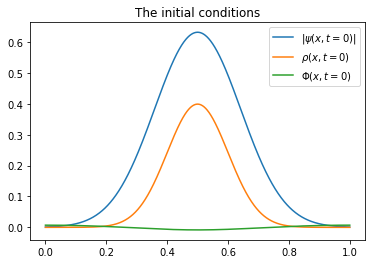

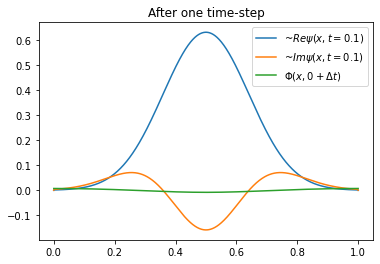

In [5]:
#Build the Initial Condition
N = 1000 #set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
dx = L/(N+1)
m = 1
hbar = 1

b=L/2
std=0.1
rho_init = np.array([gauss(xx,b,std) for xx in x])
psi_init = np.sqrt(rho_init) #assuming psi_init to be real valued and non-negative

phi_init = real_fourier_potential(psi_init)

#Plot initial conditions
plt.plot(x,psi_init, label = '$|\\psi(x,t=0)|$')
plt.plot(x,rho_init, label = '$\\rho(x,t=0)$')
plt.plot(x,phi_init, label = '$\\Phi(x,t=0)$')
plt.title("The initial conditions")
plt.legend()
plt.show()

#Evolve the system by one time-step
H = H_matrix(phi_init,dx,hbar,m)
Delta_t = 0.01
psi = psi_init-1j*Delta_t*np.dot(H,psi_init) #recalculate psi after the time step

#looks like I have to reset the ends to zero:
psi[-1] = 0
psi[0] = 0

#plt.plot(x,np.dot(H,psi_init), label = '') 
plt.plot(x,np.real(psi),label = '~$Re\\psi(x,t=0.1)$')
plt.plot(x,np.imag(psi),label = '~$Im\\psi(x,t=0.1)$')
plt.plot(x,real_fourier_potential(psi), label = '$\\Phi(x,0+\\Delta t)$')
plt.title("After one time-step")
plt.legend()
plt.show()

## 2. This code block is when I was trying to make a FFT solving method   
Can ignore this

C:\Users\boris\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


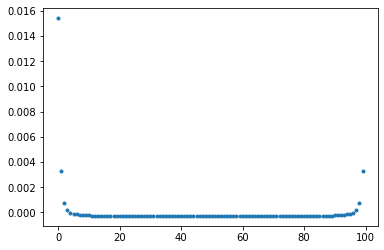

NameError: name 'output' is not defined

In [6]:
#1. FFT the norm-squared of the wave-function
P = psi*np.conj(psi)
#print(P)
n = 100 #number of frequencies to account for in FFT
P_n = np.fft.fft(P,n)
plt.plot(np.arange(0,n),P_n,'.')
plt.show()

#intermediate step: check how this fourrier series looks:
plt.plot(x,np.imag(FS(x,P_n)))
plt.plot(x,np.real(FS(x,P_n)))
plt.plot(x,np.fft.ifft(P_n,1000))
plt.plot(x,P)
plt.show()

#2. Compute the fourier coefficients of phi
Phi_n = np.array([]) #empty for storage
for n in range(len(P_n)):
    if n == 0:
        val = P_n[n]
    else:
        val = -P_n[n]/(4*np.pi*n**2/L**2)
    print(val)
    Phi_n = np.append(Phi_n,val)
print(Phi_n)
plt.plot(np.linspace(0,n,n+1),Phi_n,'r-')
plt.show()
#3. IFFT back to get Potential
Phi = np.fft.ifft(Phi_n,N)

plt.plot(x,Phi,'r-')
plt.show()



## 3. Attempt at full time-evolution calculation

Here I used a uniform density $\rho$, which I knew would give me a Harmonic potential. I tried using the initial harmonic potential that I got, to calculate the initial wave-function $\psi$ using the Laplacian matrix function I made earlier. It seems to be able to loop through everything but it's very slow. The end result should be an multi-dimensional array of arrays, where the arrays inside it are the wave-function at each time step.

1000


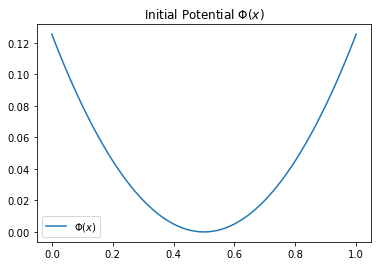

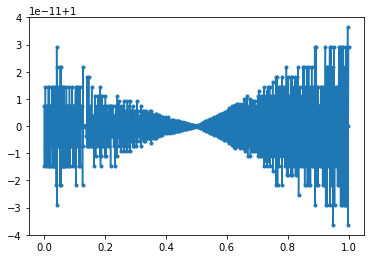

time is 0.0


NameError: name 'KE_ij' is not defined

In [7]:
#CALCULATION

#Build the Initial Condition
N = 1000 #set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
print(len(x))

#Let's try a uniform density at first. 
rho = np.ones(N, dtype= float)
#Under periodic boundary conditions and setting potential = 0 at x=L/2, this corresponds to:
#@jit(nopython=True)
def Harmonic_phi(x,L):
    return np.array([0.5*(xx-L/2)**2 for xx in x])

x_prime = np.insert(x,0,-L/(N-1))
x_prime = np.append(x_prime,L+L/(N-1))

phi = Harmonic_phi(x_prime,L)
plt.plot(x_prime,phi,label = '$\\Phi (x)$')
plt.legend()
plt.title("Initial Potential $\\Phi (x)$")
plt.show()


#Now need to get the initial wave-function psi:
psi = np.sqrt(np.absolute(Laplacian(phi,L/(N-1))))
psi = psi[1:-1] #cut off the extra ends

plt.plot(x,psi,'.-')
plt.show()
for i in range(len(psi)):
    if psi[i]>2.0:
        print(i)

#print(fourier_potential(psi,100)[0])

dt = 0.1
t_stop = 10
time = np.arange(0,10,dt)

n = 100 #resolution of fourrier transform

#storage space, with initial functions
phi_s = np.array([phi[1:-2]]) #cut off the extra ends of phi
psi_s = np.array([psi])

for t in time:
    print("time is "+str(t))

    H = np.ndarray(shape = (N,N))
    for i in range(N):
        for j in range(N):
            H[i,j] = KE_ij(i,j,N,L)+U_ij(i,j,phi)

    #Calculate the new psi after time step, then store it
    psi = psi-1j*dt*np.dot(H,psi)
    psi_s = np.append(psi_s,[psi], axis=0)

    #Re-Calculate the potential phi, then store it
    phi = real_fourier_potential(psi,n)
    phi_s = np.append(psi_s,[phi], axis = 0)



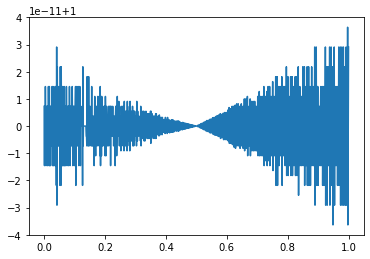

IndexError: index 1 is out of bounds for axis 0 with size 1

In [8]:
for i in range(6):
    for t in range(len(psi_s)):
        plt.plot(x,np.real(psi_s[i]))
    plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

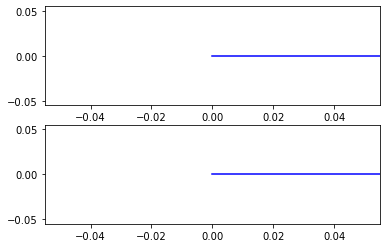

In [9]:
###################################################################################
#ANIMATION

fig, axs = plt.subplots(nrows = 2, ncols = 1)
line1_1, = axs[0].plot([],[],'r-')
line1_2, = axs[0].plot([],[],'b-')

line2_1, = axs[1].plot([],[],'r-')
line2_2, = axs[1].plot([],[],'b-')

import matplotlib.animation as animation
from IPython import display

def animate_simulation(frame,phi_s,psi_s): #take in set of phi arrays, psi array, indexed by frame number
    
    phi = phi_s[frame]
    psi = psi_s[frame]
    
    #Plot the potential
    line1_1.set_data(x,np.real(phi))
    line1_2.set_data(x,np.imag(phi))

    #Plot wave-function
    line2_1.set_data(x, np.real(psi))
    line2_2.set_data(x, np.imag(psi))


    return line1_1, line1_2, line2_1, line2_2

anim = animation.FuncAnimation(fig, animate_simulation, frames = 100, interval = 100, blit = True, fargs=(psi_s,psi_s))

# saving to m4 using ffmpeg writer
#writervideo = animation.FFMpegWriter(fps=60)
#anim.save("ToyModel.mp4", writer=writervideo)
#plt.close()

# converting to an html5 video
video = anim.to_html5_video()
  
# embedding for the video
html = display.HTML(video)
  
# draw the animation
display.display(html)
plt.close()

## 4. Trying Again: $\psi(x,t=0) = \sin^2(\pi x/L)$

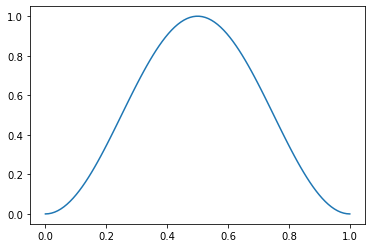

C:\Users\boris\AppData\Local\Temp\ipykernel_17640\1564703131.py:35: RuntimeWarning: invalid value encountered in multiply
  psi = psi-dt*np.dot(H,psi)*1j


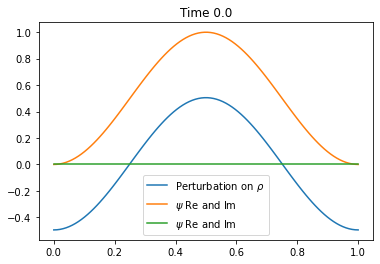

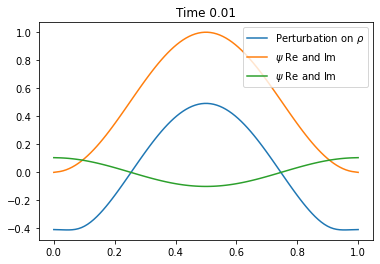

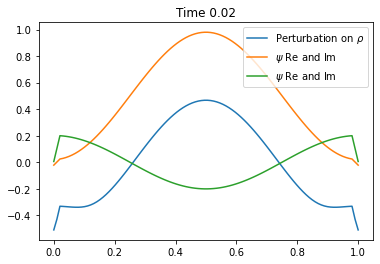

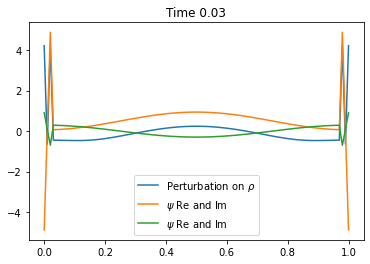

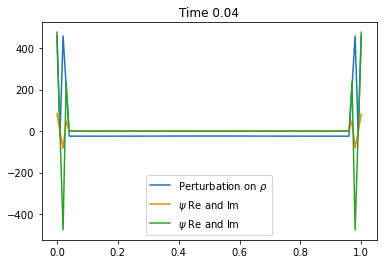

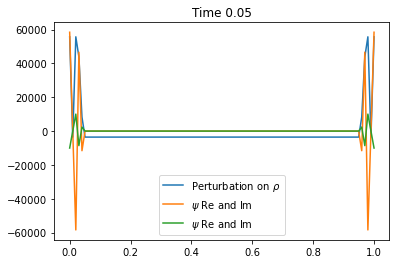

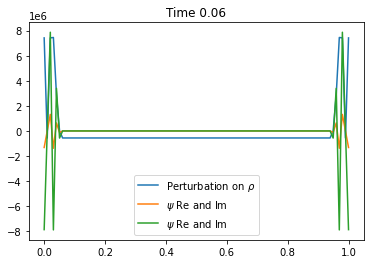

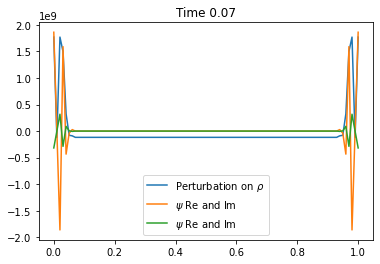

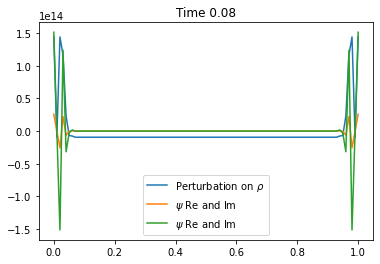

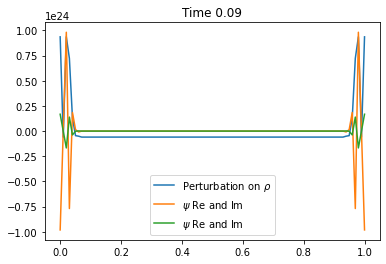

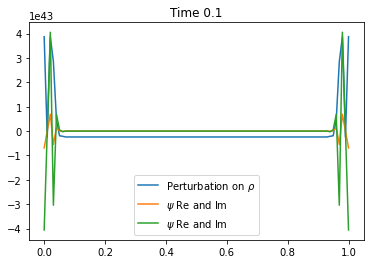

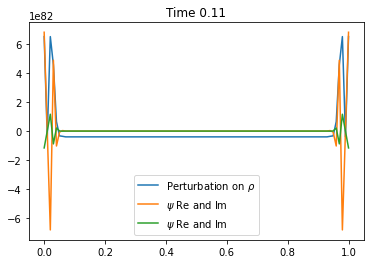

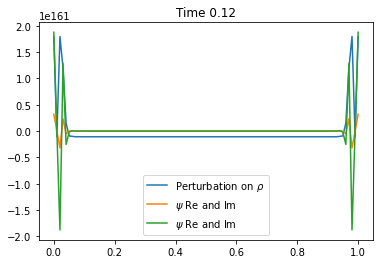

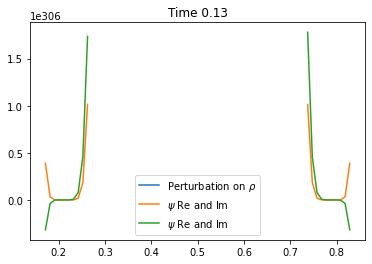

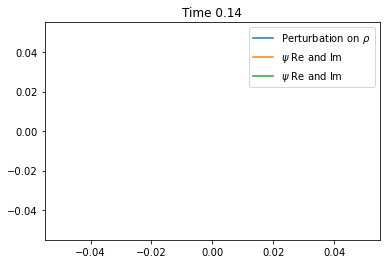

In [10]:
#CALCULATION
#Build the Initial Condition
N = 100#set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
dx = L/(N+1)
m = 1
hbar = 1

#Let's try this particular psi. 
psi = np.sin(0.5*2*np.pi*x/L)**2
plt.plot(x,psi,'-',label = '$\\psi(x,t=0)$')
plt.show()

#calculate initial (perturbation on-) density
rho = np.absolute(psi)
rho_avg = np.mean(rho)
P = rho-rho_avg

#storage space, with initial functions
P_s = np.array([P]) #initial density perturbation
psi_s = np.array([psi]) #initial wavefunction


dt = 0.01
t_stop = 10
time = 0
while time <= 10:
    #Calculate the potential phi
    phi = np.real(real_fourier_potential(psi))
    
    H = H_matrix(phi,dx,hbar,m)
    
    #Calculate the new psi after time step, then store it
    psi = psi-dt*np.dot(H,psi)*1j
    
    #do this weird correction thing to the boundary points:
    dx = L/(N-1)
    psi[0] = psi[1]+(psi[1]-psi[2])
    psi[-1] = psi[-2] - (psi[-3]-psi[-2])
    
    psi_s = np.append(psi_s,[psi], axis=0)
    
    rho = np.absolute(psi)
    P =  rho-np.mean(rho)
    P_s = np.append(P_s, [P], axis = 0)

    time += dt #forward on the clock

#plt.figure()
for i in range(15):
    #plt.figure()
    plt.plot(x,P_s[i],label = "Perturbation on $\\rho$")
    plt.plot(x,psi_s[i].real,x,psi_s[i].imag, label = "$\\psi$ Re and Im")
    plt.legend()
    plt.title(f"Time {dt*i}")
    #plt.ylim([-2,3])
    
    #now save it as a .jpg file:
    filename = 'ToyModelPlot' + str(i+1).zfill(3) + '.jpg';
    folder = "ToyModel_Images"
    plt.savefig(folder + "/" + filename)  #save this figure (includes both subplots)
    
    plt.show() #close plot so it doesn't overlap with the next one


#turn it into an animation:    
os.system("ffmpeg -y -i 'ToyModelPlot%03d.jpg' ToyModel.m4v")

from IPython.display import HTML

In [11]:
import subprocess
import glob
def generate_video(folder,N):
    #N = #number of images
    
    #img = [folder+'ToyModelPlot' + str(i+1).zfill(3) + '.jpg' for i in range(N)]
    
    #for i in xrange(len(img)):
    #    plt.imshow(img[i], cmap=cm.Greys_r)
    #    plt.savefig(folder + "/file%02d.png" % i)
    
    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'ToyModelPlot%03d.jpg', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.jpg"):
        os.remove(file_name)

generate_video("ToyModel_Images", len(P_s))

In [ ]:
###################################################################################
#ANIMATION

fig, axs = plt.subplots(nrows = 2, ncols = 1)
line1_1, = axs[0].plot([],[],'r-')
line1_2, = axs[0].plot([],[],'b-')

line2, = axs[1].plot([],[],'-')

import matplotlib.animation as animation
from IPython import display

def animate_simulation(frame,psi_s,P_s): #take in set of psi arrays, P array, indexed by frame number
    
    psi = psi_s[frame]
    P = P_s[frame]
    
    #Plot wave-function
    line1_1.set_data(x,np.real(psi))
    line1_2.set_data(x,np.imag(psi))

    #Plot density
    line2.set_data(x, np.real(P))

    return line1_1, line1_2, line2

anim = animation.FuncAnimation(fig, animate_simulation, frames = 100, interval = 100, blit = True, fargs=(psi_s,P_s))

# saving to m4 using ffmpeg writer
#writervideo = animation.FFMpegWriter(fps=60)
#anim.save("ToyModel.mp4", writer=writervideo)
#plt.close()

# converting to an html5 video
video = anim.to_html5_video()
  
# embedding for the video
html = display.HTML(video)
  
# draw the animation
display.display(html)
plt.close()

## 5. Once More: $\psi(x,t=0) = exp(-x^2/L^2)$

In [ ]:
#CALCULATION
#Build the Initial Condition
N = 100#set size
L = 1 #length of periodic box
x = np.linspace(0,L,N) #make x data / grid
#print(len(x),x[0],x[1],x[-1])

#Let's try this particular psi. 
b=L/2
std=0.1
rho_init = np.array([gauss(xx,b,std) for xx in x])
psi = np.sqrt(rho_init) #assuming psi_init to be real valued and non-negative
plt.show()

#calculate initial (perturbation on-) density
rho = np.absolute(psi)
rho_avg = np.mean(rho)
P = rho-rho_avg

#storage space, with initial functions
P_s = np.array([P]) #initial density perturbation
psi_s = np.array([psi]) #initial wavefunction


dt = 0.1
t_stop = 10
time = 0
while time <= 10:
    #Calculate the potential phi
    phi = np.real(real_fourier_potential(psi))
    
    H = H_matrix(phi,dx,hbar,m)
    
    #Calculate the new psi after time step, then store it
    psi = psi-1j*dt*np.dot(H,psi)
    
    #do this weird correction thing to the boundary points:
    dx = L/(N-1)
    psi[0] = psi[1]+(psi[1]-psi[2])
    psi[-1] = psi[-2] - (psi[-3]-psi[-2])
    
    psi_s = np.append(psi_s,[psi], axis=0)
    
    rho = np.absolute(psi)
    P = rho - np.mean(rho)
    P_s = np.append(P_s, [P], axis = 0)

    time += dt #forward on the clock

for i in range(10):
    plt.plot(x,P_s[i].real,label = "Perturbation on $\\rho$")
    plt.plot(x,psi_s[i].real, label = "$\\psi$ Re")
    plt.plot(x,psi_s[i].imag, label = "$\\psi$ Im")
    plt.legend()
    plt.title(f"Time {dt*i}")
    plt.show()